In [30]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
gen_req1 = np.load('/content/drive/My Drive/gen_req.npy')
req1 = np.load('/content/drive/My Drive/req.npy')

In [32]:
#req1 = req1[20000:2005000]
#gen_req1 = gen_req1[20000:2005000]
req1.shape,gen_req1.shape

((2005000,), (2255000,))

In [33]:
N = 100 # total ids 
pi = 3.14

LRU

In [34]:
def LRU(y, x, request_time,con):
  [N,I] = x.shape
  J = len(y)
  for j in range(J):
    x_t_j = np.zeros(N)
    file_req_time = np.zeros(N)

    # to find which users are connected to this cache 
    connected_users = []
    for k in range(I):
      if con[k,j] == 1:
        connected_users.append(k)
    for k in range(len(connected_users)):
      x_t_j += x[:,connected_users[k]]
      file_req_time = np.maximum(file_req_time, request_time[:,connected_users[k]])
    x_t_j = np.minimum(np.ones(N),x_t_j)

    a1 = np.transpose(np.logical_and(y[j],np.logical_not(np.logical_and(y[j],np.transpose(x_t_j)))))# file which is not requested but still in the cache
    b1 = np.transpose(np.logical_and(np.transpose(x_t_j),np.logical_not(np.logical_and(y[j],np.transpose(x_t_j))))) # file requested but not in the cache.
    a = np.sum(a1)
    b = np.sum(b1)

    if a>0 and b>0:
      if a>b:
        ind = []
        for k in range(N):
          if a1[k] == 1:
            ind.append(k)
        t = np.zeros(a)
        for k in range(a):
          t[k] = file_req_time[ind[k]]
        replace = (t).argsort()[:b]
        for k in range(b):
          y[j,ind[int(replace[k])]] = 0
        for k in range(N):
          if b1[k] == 1:
            y[j,k] = 1
      
      else:
        for k in range(N):
          if a1[k] == 1:
            y[j,k] = 0
        
        ind = []
        for k in range(N):
          if b1[k] == 1:
            ind.append(k)
        t = np.zeros(b)
        for k in range(b):
          t[k] = file_req_time[ind[k]]
        replace = (t).argsort()[:a]
        for k in range(a):
          y[j,ind[int(replace[k])]] = 1
  return y

LFU

In [35]:
def LFU(y,x,freq,con):
  [N,I] = x.shape
  J = len(y)

  for j in range(J):
    file_freq = np.zeros(N)
    x_t_j = np.zeros(N)

    # to find which users are connected to this cache 
    connected_users = []
    for k in range(I):
      if con[k,j] == 1:
        connected_users.append(k)
    for k in range(len(connected_users)):
      x_t_j += x[:,connected_users[k]]
      file_freq += freq[:,connected_users[k]]
    x_t_j = np.minimum(np.ones(N),x_t_j)

    a1 = np.transpose(np.logical_and(y[j],np.logical_not(np.logical_and(y[j],np.transpose(x_t_j)))))# file which is not requested but still in the cache
    b1 = np.transpose(np.logical_and(np.transpose(x_t_j),np.logical_not(np.logical_and(y[j],np.transpose(x_t_j))))) # file requested but not in the cache.
    a = np.sum(a1)
    b = np.sum(b1)
  
    if a>0 and b>0:
      if a>b:
        ind = []
        for k in range(N):
          if a1[k] == 1:
            ind.append(k)
        t = np.zeros(a)
        for k in range(a):
          t[k] = file_freq[ind[k]]
        replace = (t).argsort()[:b]
        for k in range(b):
          y[j,ind[int(replace[k])]] = 0
        for k in range(N):
          if b1[k] == 1:
            y[j,k] = 1
      else:
        for k in range(N):
          if a1[k] == 1:
            y[j,k] = 0
        ind = []
        for k in range(N):
          if b1[k] == 1:
            ind.append(k)
        t = np.zeros(b)
        for k in range(b):
          t[k] = file_freq[ind[k]]
        replace = (t).argsort()[:a]
        for k in range(a):
          y[j,ind[int(replace[k])]] = 1

  return y

perturbed count

In [36]:
def per_count(eta,count):
  [N,I] = count.shape
  p_count = np.zeros((N,I),dtype = float)
  for i in range(I):
    p_count[:,i] = count[:,i] + (eta*random.normal(0,1,[N,1])).reshape(N)
  return p_count

SINGLE CACHE

In [47]:
I = 1 #users
T = 200000
degree = 1
J = 1 #caches
C = 5
connection = np.array([[1]])
connection.shape

(1, 1)

In [48]:
req = np.zeros((I,T),dtype = int)
for i in range(I):
  for j in range(T):
    req[i,j] = req1[(i+1)*(j+1) - 1]
req.shape

(1, 200000)

In [49]:
gen_req = np.zeros((I,T),dtype = int)
for i in range(I):
  for j in range(T):
    gen_req[i,j] = gen_req1[(i+1)*(j+1) - 1]
gen_req.shape

(1, 200000)

In [50]:
y_LRU = np.zeros((J,N),dtype = float)
y_LFU = np.zeros((J,N),dtype = float)
y_FTPL = np.zeros((J,N),dtype = float)
y_LSTM = np.zeros((J,N),dtype = float)
y_LSTM[:,:C] = np.ones((J,C),dtype = float)
y_FTPL[:,:C] = np.ones((J,C),dtype = float)
y_LRU[:,:C] = np.ones((J,C),dtype = float)
y_LFU[:,:C] = np.ones((J,C),dtype = float)

count = np.zeros((N,I),dtype = float)

reward_LSTM =  np.zeros(T)
reward_FTPL =  np.zeros(T)
reward_LRU =  np.zeros(T)
reward_LFU =  np.zeros(T)
hits_FTPL =  []
hits_LRU =  []
hits_LFU =  []
hits_LSTM = []
download_FTPL =  []
download_LRU =  []
download_LFU =  []
download_LSTM = []
miss_LRU =  0
miss_LSTM =  0
miss_LFU =  0
miss_FTPL =  0


req_time = np.zeros((N,I),dtype = float) 
req_time1 = np.zeros((N,I),dtype = float) 

for t in range(T):
  old_FTPL = []
  old_LRU = []
  old_LFU = []
  old_LSTM = []
  new_FTPL = []
  new_LRU = []
  new_LFU = []
  new_LSTM = []
  for j in range(J):
    for k in range(N):
      old_LRU.append(y_LRU[j,k])
      old_LFU.append(y_LFU[j,k])
      old_FTPL.append(y_FTPL[j,k])
      old_LSTM.append(y_LSTM[j,k])
#  print(old_LRU)
  x_t1 = np.zeros((N,I),dtype = int)
  x_t = np.zeros((N,I),dtype = int)
  for i in range(I):
    x_t[req[i,t],i] += 1
    x_t1[gen_req[i,t],i] += 1
    count[int(req[i,t]),i] += 1
    req_time[int(req[i,t]),i] = t+1
    req_time1[int(gen_req[i,t]),i] = t+1
  
  ireward_LRU =  np.zeros(I)
  ireward_LSTM =  np.zeros(I)
  ireward_LFU =  np.zeros(I)
  ireward_FTPL =  np.zeros(I)
  
  for i in range(I):
    temp1 = np.zeros(N)
    temp2 = np.zeros(N)
    temp3 = np.zeros(N)
    temp4 = np.zeros(N)
    connected_cache = []
    for j in range(J):
      if connection[i,j] == 1:
        connected_cache.append(j)
    for k in range(len(connected_cache)):
      temp1 += y_FTPL[connected_cache[k],:]
      temp2 += y_LFU[connected_cache[k],:]
      temp3 += y_LRU[connected_cache[k],:]
      temp4 += y_LSTM[connected_cache[k],:]
    ireward_FTPL[i] += np.dot(np.minimum(np.ones(N),temp1),x_t[:,i])
    ireward_LFU[i] += np.dot(np.minimum(np.ones(N),temp2),x_t[:,i])
    ireward_LRU[i] += np.dot(np.minimum(np.ones(N),temp3),x_t[:,i])
    ireward_LSTM[i] += np.dot(np.minimum(np.ones(N),temp4),x_t1[:,i])

  reward_FTPL[t] =  np.sum(ireward_FTPL)
  reward_LRU[t] =  np.sum(ireward_LRU)
  reward_LFU[t] =  np.sum(ireward_LFU)
  reward_LSTM[t] =  np.sum(ireward_LSTM)
  reward_LSTMc = np.sum(reward_LSTM)
  reward_FTPLc = np.sum(reward_FTPL)
  reward_LRUc = np.sum(reward_LRU)
  reward_LFUc = np.sum(reward_LFU)


  y_LFU = LFU(y_LFU,x_t,count,connection)
  y_LRU = LRU(y_LRU,x_t,req_time,connection)
  y_LSTM = LRU(y_LSTM,x_t1,req_time1,connection)

  eta = pow(4*pi*np.log(N),-.25)*pow((t+1)/C,.5)
  perturbed_count=per_count(eta,count)

  add = (-perturbed_count[:,0]).argsort()[:C]
  y_FTPL = np.zeros((J,N),dtype = float)
  for k in range(len(add)):
    y_FTPL[0,int(add[k])] = 1 
 
  for j in range(J):
    for k in range(N):
      new_LRU.append(y_LRU[j,k])
      new_LFU.append(y_LFU[j,k])
      new_FTPL.append(y_FTPL[j,k])
      new_LSTM.append(y_LSTM[j,k])
  
#  print(old_LRU)
  miss_FTPL += (np.sum(np.logical_and(new_FTPL,np.logical_not(old_FTPL))))
  miss_LFU += (np.sum(np.logical_and(new_LFU,np.logical_not(old_LFU))))
  miss_LRU += (np.sum(np.logical_and(new_LRU,np.logical_not(old_LRU))))
  miss_LSTM += (np.sum(np.logical_and(new_LSTM,np.logical_not(old_LSTM))))
  download_LFU.append(miss_LFU)
  download_LRU.append(miss_LRU)
  download_FTPL.append(miss_FTPL)
  download_LSTM.append(miss_LSTM)

  hits_LRU.append(reward_LRUc)
  hits_LFU.append(reward_LFUc)
  hits_FTPL.append(reward_FTPLc)
  hits_LSTM.append(reward_LSTMc)

  if t %10000 == 0:
    print(t,download_FTPL[t],download_LFU[t],download_LRU[t],download_LSTM[t])

0 5 1 1 1
10000 36785 9397 9477 9477
20000 63409 18715 18994 18994
30000 85461 28029 28465 27616
40000 102549 37355 37919 36214
50000 117540 46740 47407 44815
60000 130446 56073 56865 53412
70000 141720 65392 66324 62018
80000 152426 74733 75808 70578
90000 162430 84087 85340 79217
100000 171257 93415 94835 87881
110000 179298 102743 104293 96523
120000 187359 112087 113766 105147
130000 195357 121436 123257 113729
140000 203115 130781 132765 122339
150000 211242 140113 142275 131006
160000 219462 149450 151796 139586
170000 227874 158837 161274 148243
180000 236287 168149 170803 156913
190000 244680 177520 180335 165502


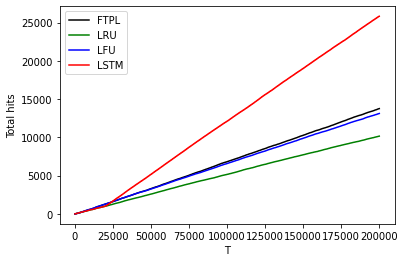

In [53]:
plt.plot(hits_FTPL,'black',label='FTPL')
plt.plot(hits_LRU,'green',label='LRU')
plt.plot(hits_LFU,'blue',label='LFU')
plt.plot(hits_LSTM,'red',label='LSTM')
plt.xlabel('T')
plt.ylabel('Total hits')
plt.legend()
plt.savefig('Total hits(I=J=1).png')

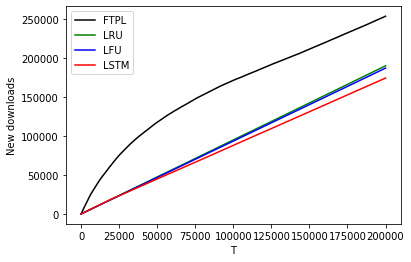

In [54]:
plt.plot(download_FTPL,'black',label='FTPL')
plt.plot(download_LRU,'green',label='LRU')
plt.plot(download_LFU,'blue',label='LFU')
plt.plot(download_LSTM,'red',label='LSTM')
plt.xlabel('T')
plt.ylabel('New downloads')
plt.legend()
plt.savefig('New downloads(I=J=1).png')

I = 5 J = 3 d = 2

In [14]:
C = 5
I = 5
J = 3
degree = 2
T = 200000

In [15]:
connection = np.zeros((I,J),dtype = int)
j = 0
for i in range(I):
    x = 0
    while x < degree:
        connection[i,j] = 1
        x += 1
        j += 1
        if j == J:
          j = 0
connection

array([[1, 1, 0],
       [1, 0, 1],
       [0, 1, 1],
       [1, 1, 0],
       [1, 0, 1]])

In [16]:
gen_req1 = np.load('/content/drive/My Drive/gen_req.npy')
req1 = np.load('/content/drive/My Drive/req.npy')
req1 = req1[20000:2005000]
gen_req1 = gen_req1[20000:2005000]

In [17]:
req = np.zeros((I,T),dtype = int)
for i in range(I):
  for j in range(T):
    req[i,j] = req1[(i+1)*(j+1) - 1]
req.shape

(5, 200000)

In [18]:
gen_req = np.zeros((I,T),dtype = int)
for i in range(I):
  for j in range(T):
    gen_req[i,j] = gen_req1[(i+1)*(j+1) - 1]
gen_req.shape

(5, 200000)

In [19]:
y_LRU = np.zeros((J,N),dtype = float)
y_LFU = np.zeros((J,N),dtype = float)
y_FTPL = np.zeros((J,N),dtype = float)
y_LSTM = np.zeros((J,N),dtype = float)
y_LSTM[:,:C] = np.ones((J,C),dtype = float)
y_FTPL[:,:C] = np.ones((J,C),dtype = float)
y_LRU[:,:C] = np.ones((J,C),dtype = float)
y_LFU[:,:C] = np.ones((J,C),dtype = float)

count = np.zeros((N,I),dtype = float)

reward_LSTM =  np.zeros(T)
reward_FTPL =  np.zeros(T)
reward_LRU =  np.zeros(T)
reward_LFU =  np.zeros(T)
hits_FTPL =  []
hits_LRU =  []
hits_LFU =  []
hits_LSTM = []
download_FTPL =  []
download_LRU =  []
download_LFU =  []
download_LSTM = []
miss_LRU =  0
miss_LSTM =  0
miss_LFU =  0
miss_FTPL =  0


req_time = np.zeros((N,I),dtype = float) 
req_time1 = np.zeros((N,I),dtype = float) 

for t in range(T):
  old_FTPL = []
  old_LRU = []
  old_LFU = []
  old_LSTM = []
  new_FTPL = []
  new_LRU = []
  new_LFU = []
  new_LSTM = []
  for j in range(J):
    for k in range(N):
      old_LRU.append(y_LRU[j,k])
      old_LFU.append(y_LFU[j,k])
      old_FTPL.append(y_FTPL[j,k])
      old_LSTM.append(y_LSTM[j,k])
#  print(old_LRU)
  x_t1 = np.zeros((N,I),dtype = int)
  x_t = np.zeros((N,I),dtype = int)
  for i in range(I):
    x_t[req[i,t],i] += 1
    x_t1[gen_req[i,t],i] += 1
    count[int(req[i,t]),i] += 1
    req_time[int(req[i,t]),i] = t+1
    req_time1[int(gen_req[i,t]),i] = t+1
  
  ireward_LRU =  np.zeros(I)
  ireward_LSTM =  np.zeros(I)
  ireward_LFU =  np.zeros(I)
  ireward_FTPL =  np.zeros(I)
  
  for i in range(I):
    temp1 = np.zeros(N)
    temp2 = np.zeros(N)
    temp3 = np.zeros(N)
    temp4 = np.zeros(N)
    connected_cache = []
    for j in range(J):
      if connection[i,j] == 1:
        connected_cache.append(j)
    for k in range(len(connected_cache)):
      temp1 += y_FTPL[connected_cache[k],:]
      temp2 += y_LFU[connected_cache[k],:]
      temp3 += y_LRU[connected_cache[k],:]
      temp4 += y_LSTM[connected_cache[k],:]
    ireward_FTPL[i] += np.dot(np.minimum(np.ones(N),temp1),x_t[:,i])
    ireward_LFU[i] += np.dot(np.minimum(np.ones(N),temp2),x_t[:,i])
    ireward_LRU[i] += np.dot(np.minimum(np.ones(N),temp3),x_t[:,i])
    ireward_LSTM[i] += np.dot(np.minimum(np.ones(N),temp4),x_t1[:,i])

  reward_FTPL[t] =  np.sum(ireward_FTPL)
  reward_LRU[t] =  np.sum(ireward_LRU)
  reward_LFU[t] =  np.sum(ireward_LFU)
  reward_LSTM[t] =  np.sum(ireward_LSTM)
  reward_LSTMc = np.sum(reward_LSTM)
  reward_FTPLc = np.sum(reward_FTPL)
  reward_LRUc = np.sum(reward_LRU)
  reward_LFUc = np.sum(reward_LFU)


  y_LFU = LFU(y_LFU,x_t,count,connection)
  y_LRU = LRU(y_LRU,x_t,req_time,connection)
  y_LSTM = LRU(y_LSTM,x_t1,req_time1,connection)

  eta = pow(4*pi*np.log(N),-.25)*pow((t+1)/C,.5)
  perturbed_count=per_count(eta,count)

  if t%1== 0:
    for j in range(J):
      max_FTPL = np.zeros(N)
      for f in range(N):
        y_FTPL[j,f] = 1
        z_FTPL = np.zeros((I,N), dtype = float)
        for i in range(I):
          for k in range(J):
            if connection[i,k] == 1:
              z_FTPL[i] += y_FTPL[k]
          z_FTPL[i] = np.minimum(np.ones(N),z_FTPL[i].reshape(N))
        max_FTPL[f] += np.dot(z_FTPL[i],perturbed_count[:,i])  
        y_FTPL[j,f] = 0
      f_FTPL = (-max_FTPL).argsort()[:C]
      for k in range (C):
        y_FTPL[j,f_FTPL[k]] = 1
  
  for j in range(J):
    for k in range(N):
      new_LRU.append(y_LRU[j,k])
      new_LFU.append(y_LFU[j,k])
      new_FTPL.append(y_FTPL[j,k])
      new_LSTM.append(y_LSTM[j,k])
  
#  print(old_LRU)
  miss_FTPL += (np.sum(np.logical_and(new_FTPL,np.logical_not(old_FTPL))))
  miss_LFU += (np.sum(np.logical_and(new_LFU,np.logical_not(old_LFU))))
  miss_LRU += (np.sum(np.logical_and(new_LRU,np.logical_not(old_LRU))))
  miss_LSTM += (np.sum(np.logical_and(new_LSTM,np.logical_not(old_LSTM))))
  download_LFU.append(miss_LFU)
  download_LRU.append(miss_LRU)
  download_FTPL.append(miss_FTPL)
  download_LSTM.append(miss_LSTM)

  hits_LRU.append(reward_LRUc)
  hits_LFU.append(reward_LFUc)
  hits_FTPL.append(reward_FTPLc)
  hits_LSTM.append(reward_LSTMc)

  if t %10000 == 0:
    print(t,download_FTPL[t],download_LFU[t],download_LRU[t],download_LSTM[t])

0 14 10 10 10
10000 67700 93041 93562 90026
20000 132444 186193 187241 180017
30000 195130 279377 281086 270289
40000 258694 372653 374997 360778
50000 323115 465691 468759 451107
60000 387486 558757 562540 541361
70000 452539 651992 656383 631571
80000 517530 745064 749999 721779
90000 582026 838110 843716 811958
100000 646265 931037 937520 902183
110000 710651 1024002 1031131 992343
120000 774787 1116902 1124730 1082574
130000 839103 1209817 1218341 1172736
140000 904431 1302881 1312112 1262727
150000 969478 1395711 1405716 1352934
160000 1034000 1488518 1499369 1443357
170000 1098723 1581649 1593232 1533395
180000 1163135 1674823 1686953 1623642
190000 1227504 1767896 1780607 1713751


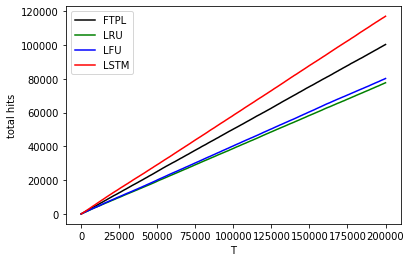

In [20]:
plt.plot(hits_FTPL,'black',label='FTPL')
plt.plot(hits_LRU,'green',label='LRU')
plt.plot(hits_LFU,'blue',label='LFU')
plt.plot(hits_LSTM,'red',label='LSTM')
plt.xlabel('T')
plt.ylabel('total hits')
plt.legend()
plt.savefig('Total hits(I=5 J=3 d=2).png')

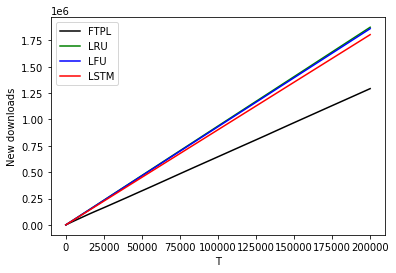

In [21]:
plt.plot(download_FTPL,'black',label='FTPL')
plt.plot(download_LRU,'green',label='LRU')
plt.plot(download_LFU,'blue',label='LFU')
plt.plot(download_LSTM,'red',label='LSTM')
plt.xlabel('T')
plt.ylabel('New downloads')
plt.legend()
plt.savefig('New downloads(I=5 J=3 d=2).png')

I = 15 J = 10 d = 7

In [22]:
I = 15
J = 10
C = 10
degree = 7
T = 10000

In [23]:
connection = np.zeros((I,J),dtype = int)
j = 0
for i in range(I):
    x = 0
    while x < degree:
        connection[i,j] = 1
        x += 1
        j += 1
        if j == J:
          j = 0

In [24]:
req = np.zeros((I,T),dtype = int)
for i in range(I):
  for j in range(T):
    req[i,j] = req1[(i+1)*(j+1) - 1]
req.shape

(15, 10000)

In [25]:
gen_req = np.zeros((I,T),dtype = int)
for i in range(I):
  for j in range(T):
    gen_req[i,j] = gen_req1[(i+1)*(j+1) - 1]
gen_req.shape

(15, 10000)

In [27]:
y_LRU = np.zeros((J,N),dtype = float)
y_LFU = np.zeros((J,N),dtype = float)
y_FTPL = np.zeros((J,N),dtype = float)
y_LSTM = np.zeros((J,N),dtype = float)
y_LSTM[:,:C] = np.ones((J,C),dtype = float)
y_FTPL[:,:C] = np.ones((J,C),dtype = float)
y_LRU[:,:C] = np.ones((J,C),dtype = float)
y_LFU[:,:C] = np.ones((J,C),dtype = float)

count = np.zeros((N,I),dtype = float)

reward_LSTM =  np.zeros(T)
reward_FTPL =  np.zeros(T)
reward_LRU =  np.zeros(T)
reward_LFU =  np.zeros(T)
hits_FTPL =  []
hits_LRU =  []
hits_LFU =  []
hits_LSTM = []
download_FTPL =  []
download_LRU =  []
download_LFU =  []
download_LSTM = []
miss_LRU =  0
miss_LSTM =  0
miss_LFU =  0
miss_FTPL =  0
req_time = np.zeros((N,I),dtype = float) 
req_time1 = np.zeros((N,I),dtype = float) 

for t in range(T):
  old_FTPL = []
  old_LRU = []
  old_LFU = []
  old_LSTM = []
  new_FTPL = []
  new_LRU = []
  new_LFU = []
  new_LSTM = []
  for j in range(J):
    for k in range(N):
      old_LRU.append(y_LRU[j,k])
      old_LFU.append(y_LFU[j,k])
      old_FTPL.append(y_FTPL[j,k])
      old_LSTM.append(y_LSTM[j,k])
#  print(old_LRU)
  x_t1 = np.zeros((N,I),dtype = int)
  x_t = np.zeros((N,I),dtype = int)
  for i in range(I):
    x_t[req[i,t],i] += 1
    x_t1[gen_req[i,t],i] += 1
    count[int(req[i,t]),i] += 1
    req_time[int(req[i,t]),i] = t+1
    req_time1[int(gen_req[i,t]),i] = t+1
  
  ireward_LRU =  np.zeros(I)
  ireward_LSTM =  np.zeros(I)
  ireward_LFU =  np.zeros(I)
  ireward_FTPL =  np.zeros(I)
  
  for i in range(I):
    temp1 = np.zeros(N)
    temp2 = np.zeros(N)
    temp3 = np.zeros(N)
    temp4 = np.zeros(N)
    connected_cache = []
    for j in range(J):
      if connection[i,j] == 1:
        connected_cache.append(j)
    for k in range(len(connected_cache)):
      temp1 += y_FTPL[connected_cache[k],:]
      temp2 += y_LFU[connected_cache[k],:]
      temp3 += y_LRU[connected_cache[k],:]
      temp4 += y_LSTM[connected_cache[k],:]
    ireward_FTPL[i] += np.dot(np.minimum(np.ones(N),temp1),x_t[:,i])
    ireward_LFU[i] += np.dot(np.minimum(np.ones(N),temp2),x_t[:,i])
    ireward_LRU[i] += np.dot(np.minimum(np.ones(N),temp3),x_t[:,i])
    ireward_LSTM[i] += np.dot(np.minimum(np.ones(N),temp4),x_t1[:,i])

  reward_FTPL[t] =  np.sum(ireward_FTPL)
  reward_LRU[t] =  np.sum(ireward_LRU)
  reward_LFU[t] =  np.sum(ireward_LFU)
  reward_LSTM[t] =  np.sum(ireward_LSTM)
  reward_LSTMc = np.sum(reward_LSTM)
  reward_FTPLc = np.sum(reward_FTPL)
  reward_LRUc = np.sum(reward_LRU)
  reward_LFUc = np.sum(reward_LFU)


  y_LFU = LFU(y_LFU,x_t,count,connection)
  y_LRU = LRU(y_LRU,x_t,req_time,connection)
  y_LSTM = LRU(y_LSTM,x_t1,req_time1,connection)

  eta = pow(4*pi*np.log(N),-.25)*pow((t+1)/C,.5)
  perturbed_count=per_count(eta,count)

  if t%1 == 0:
    for j in range(J):
      max_FTPL = np.zeros(N)
      for f in range(N):
        y_FTPL[j,f] = 1
        z_FTPL = np.zeros((I,N), dtype = float)
        for i in range(I):
          for k in range(J):
            if connection[i,k] == 1:
              z_FTPL[i] += y_FTPL[k]
          z_FTPL[i] = np.minimum(np.ones(N),z_FTPL[i].reshape(N))
        max_FTPL[f] += np.dot(z_FTPL[i],perturbed_count[:,i])  
        y_FTPL[j,f] = 0
      f_FTPL = (-max_FTPL).argsort()[:C]
      for k in range (C):
        y_FTPL[j,f_FTPL[k]] = 1
  
  for j in range(J):
    for k in range(N):
      new_LRU.append(y_LRU[j,k])
      new_LFU.append(y_LFU[j,k])
      new_FTPL.append(y_FTPL[j,k])
      new_LSTM.append(y_LSTM[j,k])
  
#  print(old_LRU)
  miss_FTPL += (np.sum(np.logical_and(new_FTPL,np.logical_not(old_FTPL))))
  miss_LFU += (np.sum(np.logical_and(new_LFU,np.logical_not(old_LFU))))
  miss_LRU += (np.sum(np.logical_and(new_LRU,np.logical_not(old_LRU))))
  miss_LSTM += (np.sum(np.logical_and(new_LSTM,np.logical_not(old_LSTM))))
  download_LFU.append(miss_LFU)
  download_LRU.append(miss_LRU)
  download_FTPL.append(miss_FTPL)
  download_LSTM.append(miss_LSTM)

  hits_LRU.append(reward_LRUc)
  hits_LFU.append(reward_LFUc)
  hits_FTPL.append(reward_FTPLc)
  hits_LSTM.append(reward_LSTMc)

  if t %1000 == 0:
    print(t,hits_FTPL[t],hits_LFU[t],hits_LRU[t],hits_LSTM[t],download_FTPL[t],download_LFU[t],download_LRU[t],download_LSTM[t])

0 1.0 1.0 1.0 0.0 90 86 86 60
1000 7244.0 2335.0 2273.0 2743.0 57860 87136 87167 84131
2000 14412.0 4664.0 4527.0 5571.0 114828 174248 174311 167906
3000 21580.0 6996.0 6826.0 8408.0 172328 261496 261493 251709
4000 28680.0 9322.0 9089.0 11248.0 229373 348538 348603 335254
5000 35764.0 11608.0 11327.0 14171.0 286291 435653 435654 418302
6000 42961.0 13926.0 13588.0 16946.0 343343 522790 522855 502187
7000 50154.0 16306.0 15949.0 19798.0 400211 609609 609674 585837
8000 57418.0 18685.0 18247.0 22673.0 457144 696493 696544 669359
9000 64536.0 21011.0 20507.0 25536.0 514068 783627 783684 752517


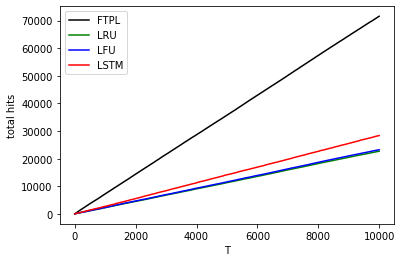

In [28]:
plt.plot(hits_FTPL,'black',label='FTPL')
plt.plot(hits_LRU,'green',label='LRU')
plt.plot(hits_LFU,'blue',label='LFU')
plt.plot(hits_LSTM,'red',label='LSTM')
plt.xlabel('T')
plt.ylabel('total hits')
plt.legend()
plt.savefig('Total hits(I=15 J=10 d=7).png')

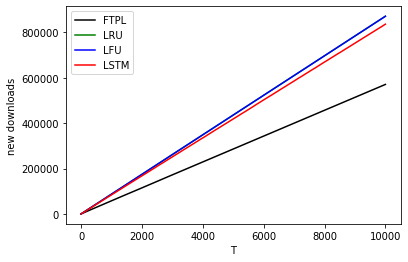

In [29]:
plt.plot(download_FTPL,'black',label='FTPL')
plt.plot(download_LRU,'green',label='LRU')
plt.plot(download_LFU,'blue',label='LFU')
plt.plot(download_LSTM,'red',label='LSTM')
plt.xlabel('T')
plt.ylabel('new downloads')
plt.legend()
plt.savefig('New downloads(I=15 J=10 d=7).png')